In [3]:
pip install "numpy>=1.16.5,<1.23.0"

Note: you may need to restart the kernel to use updated packages.


In [4]:
import numpy as np 
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import pandas as pd
import pickle
import ast
#pd.set_option('display.max_columns', None)
#pd.set_option('display.width', 500)
#pd.set_option('max_colwidth', 150) #Kolondaki verilerin tüm içeriğini görebilmek için
#pd.set_option('display.expand_frame_repr', False)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

warnings.simplefilter(action='ignore', category=Warning)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/kaggle/input/pickles/seg1_tfidf_matrix.pkl
/kaggle/input/pickles/seg1_vectorizer.pkl
/kaggle/input/food-com-recipes-and-user-interactions/RAW_interactions.csv
/kaggle/input/food-com-recipes-and-user-interactions/ingr_map.pkl
/kaggle/input/food-com-recipes-and-user-interactions/PP_recipes.csv
/kaggle/input/food-com-recipes-and-user-interactions/RAW_recipes.csv
/kaggle/input/food-com-recipes-and-user-interactions/interactions_train.csv
/kaggle/input/food-com-recipes-and-user-interactions/interactions_test.csv
/kaggle/input/food-com-recipes-and-user-interactions/PP_users.csv
/kaggle/input/food-com-recipes-and-user-interactions/interactions_validation.csv


This dataset consists of 230K recipes and 1.1M user-recipe interactions (reviews) scraped from Food.com (formerly GeniusKitchen), covering a period of 18 years (January 2000 to December 2018).

In [5]:
raw_recipes=pd.read_csv('/kaggle/input/food-com-recipes-and-user-interactions/RAW_recipes.csv')
raw_recipes.head()
raw_recipes.columns
raw_recipes.shape

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8


Index(['name', 'id', 'minutes', 'contributor_id', 'submitted', 'tags',
       'nutrition', 'n_steps', 'steps', 'description', 'ingredients',
       'n_ingredients'],
      dtype='object')

(231637, 12)

In [6]:
raw_interactions=pd.read_csv('/kaggle/input/food-com-recipes-and-user-interactions/RAW_interactions.csv')
raw_interactions.head()
raw_interactions.columns
raw_interactions.shape

,user_id,recipe_id,date,rating,review
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall..."
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...
3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...
4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin..."


Index(['user_id', 'recipe_id', 'date', 'rating', 'review'], dtype='object')

(1132367, 5)

In [7]:
ingr_map = joblib.load("/kaggle/input/food-com-recipes-and-user-interactions/ingr_map.pkl")
ingr_map.head()
ingr_map.columns
ingr_map.shape

,raw_ingr,raw_words,processed,len_proc,replaced,count,id
0,"medium heads bibb or red leaf lettuce, washed,...",13,"medium heads bibb or red leaf lettuce, washed,...",73,lettuce,4507,4308
1,mixed baby lettuces and spring greens,6,mixed baby lettuces and spring green,36,lettuce,4507,4308
2,romaine lettuce leaf,3,romaine lettuce leaf,20,lettuce,4507,4308
3,iceberg lettuce leaf,3,iceberg lettuce leaf,20,lettuce,4507,4308
4,red romaine lettuce,3,red romaine lettuce,19,lettuce,4507,4308


Index(['raw_ingr', 'raw_words', 'processed', 'len_proc', 'replaced', 'count',
       'id'],
      dtype='object')

(11659, 7)

In [9]:
#rating sayıları
raw_interactions.rating.value_counts(dropna=False)

5    816364
4    187360
0     60847
3     40855
2     14123
1     12818
Name: rating, dtype: int64

In [8]:
#rating = 0 olanlar elenir
raw_interactions=raw_interactions[raw_interactions.rating>0]

In [11]:
raw_interactions.recipe_id.nunique() #226590 farklı tarif kaldı

226590

In [9]:
#Tariflerin yorum sayısı ve ortalamasına göre gruplanması
grouped=raw_interactions.groupby('recipe_id').agg({'rating':['count', 'mean']}).reset_index()
grouped.columns=grouped.columns.droplevel(0)
grouped.columns=['recipe_id','rating_count','rating_mean']
grouped.sort_values(by='rating_count',ascending=False)

,recipe_id,rating_count,rating_mean
14156,27208,1496,4.589572
50549,89204,1488,4.478495
818,2886,1401,4.819415
21268,39087,1359,4.838852
38015,67256,1194,4.793132
...,...,...,...
120087,219413,1,5.000000
120084,219408,1,3.000000
120082,219404,1,5.000000
120078,219397,1,5.000000


In [13]:
len(grouped[grouped['rating_count']>=40]) #40 veya daha fazla yorum almıs tarif sayısı 2730

#bu 2730 tarifin rating ortalaması 3.4 ile 5 arasındadır.
grouped[grouped['rating_count']>=40].rating_mean.max(), grouped[grouped['rating_count']>=40].rating_mean.min()

grouped[grouped['rating_count']>=40].rating_mean.value_counts() 

2730

(5.0, 3.4693877551020407)

4.800000    30
4.750000    26
4.666667    21
4.714286    19
4.857143    19
            ..
4.520833     1
4.957265     1
4.577844     1
4.522088     1
3.825000     1
Name: rating_mean, Length: 1447, dtype: int64

In [14]:
#40tan fazla yorum alan 2730 tarifin id'si bir listeye alınır
recipes_to_filter=list(grouped[grouped['rating_count']>=40].recipe_id)

In [15]:
#Tarif veriseti bu 2730 tarif ile filtrelenir.
filtered_recipes=raw_recipes[raw_recipes.id.isin(recipes_to_filter)]
filtered_recipes.head(3)

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
36,how i got my family to eat spinach spinach ca...,25775,50,37305,2002-04-22,"['60-minutes-or-less', 'time-to-make', 'course...","[166.1, 16.0, 6.0, 32.0, 19.0, 26.0, 3.0]",5,"['preheat oven to 350 degrees', 'place spinach...","if spinach scares you, this is one recipe that...","['frozen chopped spinach', 'egg', 'salt', 'bla...",8
53,land of nod cinnamon buns,22526,35,29212,2002-03-14,"['60-minutes-or-less', 'time-to-make', 'course...","[575.3, 18.0, 116.0, 34.0, 28.0, 22.0, 34.0]",7,"['before you turn in for the night , grease a ...",i have made this several times and it's dead e...,"['rolls', 'brown sugar', 'instant vanilla pudd...",6
67,never weep whipped cream,74805,5,87877,2003-11-01,"['15-minutes-or-less', 'time-to-make', 'course...","[276.3, 45.0, 2.0, 1.0, 3.0, 91.0, 0.0]",4,['whip all ingredients together until firm pea...,"i don't know where i got this, but it works. t...","['whipping cream', 'vanilla instant pudding mi...",4


In [87]:
del raw_recipes
del raw_interactions

# Filtered Recipes İnceleme

In [16]:
#Tariflerin ID veya isimlerinde çoklama var mı?
filtered_recipes.id.nunique() #2730 id lerinde çoklama yok
filtered_recipes.name.nunique()#2728 , 2 tarifin ismi aynı görünüyor

filtered_recipes.name.value_counts() #Aynı isimle 2 kez veride yer alan tarifler: roasted brussels sprouts , strawberry rhubarb pie

2730

2728

roasted brussels sprouts                                     2
strawberry rhubarb pie                                       2
how i got my family to eat spinach  spinach casserole        1
on the go ravioli lasagna                                    1
one dish chicken and rice bake                               1
                                                            ..
easiest chocolate peanut butter fudge                        1
easiest tastiest barbecue country style ribs  slow cooker    1
easter nests with jelly bean eggs                            1
easter sunday cheesecake                                     1
zucchini salsa  canned                                       1
Name: name, Length: 2728, dtype: int64

In [17]:
#İsmi çoklayan 2 tarifin detaylarına bakalım
filtered_recipes[filtered_recipes.name.isin(['roasted brussels sprouts','strawberry rhubarb pie'])]

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
175197,roasted brussels sprouts,201073,30,242161,2006-12-19,"['lactose', '30-minutes-or-less', 'time-to-mak...","[165.0, 16.0, 15.0, 13.0, 11.0, 7.0, 5.0]",5,"['preheat oven to 400 degrees f', 'cut the bot...","quick, simple, and unbelievably tasty. this re...","['fresh brussels sprouts', 'extra virgin olive...",6
175222,roasted brussels sprouts,56103,50,37449,2003-03-10,"['60-minutes-or-less', 'time-to-make', 'course...","[101.0, 11.0, 7.0, 9.0, 5.0, 5.0, 2.0]",6,"['preheat oven to 400f', 'cut off the ends of ...",i got this from the barefoot contessa cookbook...,"['brussels sprouts', 'olive oil', 'kosher salt...",4
201246,strawberry rhubarb pie,125515,120,70073,2005-06-10,"['time-to-make', 'course', 'main-ingredient', ...","[178.1, 1.0, 143.0, 0.0, 3.0, 1.0, 14.0]",13,"['in a bowl , combine rhubarb , strawberries ,...",an excellent pie to make when strawberries and...,"['rhubarb', 'strawberries', 'granulated sugar'...",9
201598,strawberry rhubarb pie,7553,40,146310,2000-03-13,"['60-minutes-or-less', 'time-to-make', 'course...","[343.5, 15.0, 176.0, 12.0, 10.0, 17.0, 19.0]",11,"['combine eggs , sugar , flour , salt , and nu...",NaN,"['eggs', 'rhubarb', 'sugar', 'strawberries', '...",9


In [18]:
#İsmi çoklayan 2'şer tariften hangilerinin seçileceğine karar verilemeyecektir, elenirler. 
filtered_recipes=filtered_recipes[~filtered_recipes.name.isin(['roasted brussels sprouts','strawberry rhubarb pie'])]
len(filtered_recipes) #2726 adet farklı tarif kaldı

2726

# Nutrition

In [19]:
filtered_recipes[['calories','total fat (PDV)','sugar (PDV)','sodium (PDV)','protein (PDV)','saturated fat (PDV)','carbohydrates (PDV)']] = filtered_recipes.nutrition.apply(lambda x: x.replace('[', '').replace(']', '')).str.split(",",expand=True).astype('float')

# Outlier Analizi

In [20]:
#Outlier Functions
def outlier_thresholds(dataframe, col_name, q1, q3):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def check_outlier(dataframe, col_name, q1, q3):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name, q1,q3)
    return dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None)
    
def replace_with_thresholds(dataframe, variable,q1,q3):
    low_limit, up_limit = outlier_thresholds(dataframe, variable,q1,q3)
    #dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [21]:
filtered_recipes.describe()

,id,minutes,contributor_id,n_steps,n_ingredients,calories,total fat (PDV),sugar (PDV),sodium (PDV),protein (PDV),saturated fat (PDV),carbohydrates (PDV)
count,2726.000000,2726.000000,2.726000e+03,2726.000000,2726.000000,2726.000000,2726.000000,2726.000000,2726.000000,2726.000000,2726.000000,2726.000000
mean,91408.446809,102.357667,2.089716e+06,9.642333,8.852898,455.402494,34.288701,72.431401,36.111886,38.355833,43.878944,14.264490
std,86029.308475,485.365263,5.977692e+07,5.864597,3.600001,1062.208676,104.739071,182.760306,125.543035,136.190564,126.556888,31.464804
min,198.000000,0.000000,2.700000e+01,1.000000,2.000000,1.700000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,31321.000000,25.000000,2.739500e+04,6.000000,6.000000,176.800000,9.000000,8.000000,7.250000,7.000000,8.000000,4.000000
50%,69182.000000,40.000000,5.228200e+04,8.000000,9.000000,312.350000,20.000000,23.000000,18.000000,17.000000,23.000000,9.000000
75%,116994.250000,70.000000,1.111410e+05,12.000000,11.000000,507.675000,39.000000,68.000000,38.000000,53.000000,52.000000,16.000000
max,524863.000000,20190.000000,1.802810e+09,70.000000,29.000000,38680.100000,4317.000000,4601.000000,4554.000000,6540.000000,4960.000000,1188.000000


In [22]:
filtered_recipes.describe(percentiles=[0.8,0.9,0.95,0.99])

,id,minutes,contributor_id,n_steps,n_ingredients,calories,total fat (PDV),sugar (PDV),sodium (PDV),protein (PDV),saturated fat (PDV),carbohydrates (PDV)
count,2726.000000,2726.000000,2.726000e+03,2726.000000,2726.000000,2726.000000,2726.000000,2726.000000,2726.000000,2726.000000,2726.000000,2726.000000
mean,91408.446809,102.357667,2.089716e+06,9.642333,8.852898,455.402494,34.288701,72.431401,36.111886,38.355833,43.878944,14.264490
std,86029.308475,485.365263,5.977692e+07,5.864597,3.600001,1062.208676,104.739071,182.760306,125.543035,136.190564,126.556888,31.464804
min,198.000000,0.000000,2.700000e+01,1.000000,2.000000,1.700000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,69182.000000,40.000000,5.228200e+04,8.000000,9.000000,312.350000,20.000000,23.000000,18.000000,17.000000,23.000000,9.000000
80%,134924.000000,85.000000,1.379110e+05,13.000000,12.000000,571.900000,44.000000,87.000000,45.000000,62.000000,59.000000,18.000000
90%,190966.000000,185.000000,2.176570e+05,16.500000,13.500000,823.800000,68.000000,160.500000,67.000000,86.000000,95.000000,27.000000
95%,258450.750000,365.000000,3.228592e+05,20.000000,15.000000,1133.425000,97.000000,263.000000,97.000000,109.000000,134.000000,40.000000
99%,474870.250000,927.500000,1.113008e+06,30.000000,20.000000,2746.700000,217.750000,941.500000,254.250000,184.500000,297.500000,128.750000
max,524863.000000,20190.000000,1.802810e+09,70.000000,29.000000,38680.100000,4317.000000,4601.000000,4554.000000,6540.000000,4960.000000,1188.000000


In [93]:
filtered_recipes.dtypes

name                    object
id                       int64
minutes                  int64
contributor_id           int64
submitted               object
tags                    object
nutrition               object
n_steps                  int64
steps                   object
description             object
ingredients             object
n_ingredients            int64
calories               float64
total fat (PDV)        float64
sugar (PDV)            float64
sodium (PDV)           float64
protein (PDV)          float64
saturated fat (PDV)    float64
carbohydrates (PDV)    float64
dtype: object

In [21]:
#Outlier baskılama için numeric kolonlar seçilir.
num_cols = ['minutes', 'n_steps', 'n_ingredients', 'calories', 'total fat (PDV)', 'sugar (PDV)', 'sodium (PDV)', 'protein (PDV)', 'saturated fat (PDV)', 'carbohydrates (PDV)']

In [24]:
print('q1=0.01, q3=0.99 için outlier analizi')
for col in num_cols:
    print(f'{col} has outlier {check_outlier(filtered_recipes, col,q1=0.01, q3=0.99)} and values {outlier_thresholds(filtered_recipes,col,q1=0.01, q3=0.99)}')

q1=0.01, q3=0.99 için outlier analizi
minutes has outlier True and values (-1383.75, 2314.25)
n_steps has outlier False and values (-40.0, 72.0)
n_ingredients has outlier False and values (-25.0, 47.0)
calories has outlier True and values (-4072.6124999999997, 6838.287499999999)
total fat (PDV) has outlier True and values (-326.625, 544.375)
sugar (PDV) has outlier True and values (-1412.25, 2353.75)
sodium (PDV) has outlier True and values (-381.375, 635.625)
protein (PDV) has outlier True and values (-276.75, 461.25)
saturated fat (PDV) has outlier True and values (-446.25, 743.75)
carbohydrates (PDV) has outlier True and values (-193.125, 321.875)


In [25]:
print('q1=0.05, q3=0.95 için outlier analizi')
for col in num_cols:
    print(f'{col} has outlier {check_outlier(filtered_recipes, col,q1=0.05, q3=0.95)} and values {outlier_thresholds(filtered_recipes,col,q1=0.05, q3=0.95)}')

q1=0.05, q3=0.95 için outlier analizi
minutes has outlier True and values (-532.5, 903.5)
n_steps has outlier True and values (-22.5, 45.5)
n_ingredients has outlier False and values (-12.5, 31.5)
calories has outlier True and values (-1521.575, 2726.425)
total fat (PDV) has outlier True and values (-145.5, 242.5)
sugar (PDV) has outlier True and values (-394.5, 657.5)
sodium (PDV) has outlier True and values (-143.0, 241.0)
protein (PDV) has outlier True and values (-161.0, 271.0)
saturated fat (PDV) has outlier True and values (-201.0, 335.0)
carbohydrates (PDV) has outlier True and values (-60.0, 100.0)


In [26]:
print('q1=0.2, q3=0.8 için outlier analizi')
for col in num_cols:
    print(f'{col} has outlier {check_outlier(filtered_recipes, col,q1=0.2, q3=0.8)} and values {outlier_thresholds(filtered_recipes,col,q1=0.2, q3=0.8)}')

q1=0.2, q3=0.8 için outlier analizi
minutes has outlier True and values (-77.5, 182.5)
n_steps has outlier True and values (-7.0, 25.0)
n_ingredients has outlier True and values (-3.0, 21.0)
calories has outlier True and values (-474.59999999999997, 1199.8)
total fat (PDV) has outlier True and values (-48.5, 99.5)
sugar (PDV) has outlier True and values (-115.5, 208.5)
sodium (PDV) has outlier True and values (-52.5, 103.5)
protein (PDV) has outlier True and values (-78.0, 146.0)
saturated fat (PDV) has outlier True and values (-73.5, 138.5)
carbohydrates (PDV) has outlier True and values (-19.5, 40.5)


### Outlier degerleri ust limitleri 0.8 ile doldurulmaya karar verildi

In [22]:
for col in num_cols:
    filtered_recipes.col= replace_with_thresholds(filtered_recipes, col,q1=0.2, q3=0.8)

In [28]:
filtered_recipes.describe()

,id,minutes,contributor_id,n_steps,n_ingredients,calories,total fat (PDV),sugar (PDV),sodium (PDV),protein (PDV),saturated fat (PDV),carbohydrates (PDV)
count,2726.000000,2726.000000,2.726000e+03,2726.000000,2726.000000,2726.000000,2726.000000,2726.000000,2726.000000,2726.000000,2726.000000,2726.000000
mean,91408.446809,59.797689,2.089716e+06,9.466985,8.841526,389.851724,28.181585,50.436720,27.139398,33.781731,36.185437,11.524028
std,86029.308475,52.784826,5.977692e+07,5.077980,3.552673,293.220108,26.339600,61.457033,27.010097,35.634450,37.352008,10.488643
min,198.000000,0.000000,2.700000e+01,1.000000,2.000000,1.700000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,31321.000000,25.000000,2.739500e+04,6.000000,6.000000,176.800000,9.000000,8.000000,7.250000,7.000000,8.000000,4.000000
50%,69182.000000,40.000000,5.228200e+04,8.000000,9.000000,312.350000,20.000000,23.000000,18.000000,17.000000,23.000000,9.000000
75%,116994.250000,70.000000,1.111410e+05,12.000000,11.000000,507.675000,39.000000,68.000000,38.000000,53.000000,52.000000,16.000000
max,524863.000000,182.500000,1.802810e+09,25.000000,21.000000,1199.800000,99.500000,208.500000,103.500000,146.000000,138.500000,40.500000


### Minute = 0  , Adim sayisi n_steps = 1 , Malzeme sayisi n_ingredients = 2 olan kayitlar incelenir

In [23]:
filtered_recipes[filtered_recipes.minutes==0] #veriden cikarilir
filtered_recipes= filtered_recipes[~(filtered_recipes.minutes==0)]

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,calories,total fat (PDV),sugar (PDV),sodium (PDV),protein (PDV),saturated fat (PDV),carbohydrates (PDV)
32319,buttermilk southern fried chicken,3294,0.0,64203,1999-10-11,"['15-minutes-or-less', 'time-to-make', 'main-i...","[655.4, 55.0, 24.0, 60.0, 99.0, 52.0, 10.0]",13,"['wash chicken pieces thoroughly and pat dry',...",NaN,"['frying chickens', 'buttermilk', 'all-purpose...",9,655.4,55.0,24.0,60.0,99.0,52.0,10.0
72961,double chocolate banana muffins,9327,0.0,6357,2001-06-04,"['15-minutes-or-less', 'time-to-make', 'course...","[403.4, 25.0, 159.0, 13.0, 9.0, 27.0, 21.0]",6,"['in a large bowl , combine the first six ingr...",NaN,"['flour', 'sugar', 'baking cocoa', 'baking sod...",10,403.4,25.0,159.0,13.0,9.0,27.0,21.0
81608,fabulous zucchini bread,3877,0.0,1534,1999-11-02,"['15-minutes-or-less', 'time-to-make', 'course...","[927.0, 45.0, 332.0, 40.0, 35.0, 22.0, 51.0]",11,"['preheat oven to 350 degrees', 'cream togethe...",NaN,"['eggs', 'applesauce', 'oil', 'granulated suga...",17,927.0,45.0,208.5,40.0,35.0,22.0,40.5
110614,illinois apple pie,8423,0.0,64203,2000-03-16,"['15-minutes-or-less', 'time-to-make', 'course...","[711.3, 57.0, 224.0, 9.0, 10.0, 50.0, 31.0]",24,"['preheat oven to 450 degrees', 'for crust , c...",i adopted this recipe during the recipezaar ab...,"['all-purpose flour', 'salt', 'crisco shorteni...",12,711.3,57.0,208.5,9.0,10.0,50.0,31.0
129344,mandarin pork chops,4143,0.0,1543,1999-11-07,"['15-minutes-or-less', 'time-to-make', 'main-i...","[477.3, 33.0, 87.0, 5.0, 84.0, 32.0, 9.0]",10,"['in large skillet , brown chops in oil', 'rem...",NaN,"['pork chops', 'vegetable oil', 'orange juice'...",10,477.3,33.0,87.0,5.0,84.0,32.0,9.0
220660,vanilla pudding,4271,0.0,1534,1999-11-11,"['15-minutes-or-less', 'time-to-make', 'course...","[270.9, 14.0, 120.0, 13.0, 11.0, 25.0, 13.0]",11,"['in medium double boiler , cook sugar , corns...",NaN,"['sugar', 'cornstarch', 'milk', 'salt', 'egg y...",7,270.9,14.0,120.0,13.0,11.0,25.0,13.0


In [40]:
#filtered_recipes[filtered_recipes.n_steps==1] #veride tutulur

In [42]:
#filtered_recipes[filtered_recipes.n_ingredients==2]  #veride tutulur

In [45]:
#filtered_recipes[filtered_recipes.calories<=5] #veride tutulur

### Tarif dosyasindaki gerekli elemeler yapildi. Tarif id'leri bir dataframede tutulur ve csv dosyasina alinir.

In [24]:
#Verisetinin indexi 0 dan başlaması için resetlenir.
filtered_recipes.reset_index(drop=True, inplace=True)

In [31]:
filtered_recipes[['id','name']].to_csv('final_repices.csv',index=False) #sadece id-name eslesmesi

#### Verideki tags kolonu da benzerlikte corpus icinde kullanilacagi icin user tarafindan secilmesi istenen degerler, bu degerler de streamlit uygulamasinda kullanilmak uzere bir csv dosyasina export edilir.

In [93]:
tag_lists = filtered_recipes.tags.tolist()
merged_list = []
for tag_list in tag_lists:
    merged_list.extend(tag_list)
    
distinct_tags = list(set(merged_list))
len(distinct_tags)

414

In [94]:
#414 tag icinden frekansi yuksek olanlar arasindan secim yapilacaktir, frekanslarina bakilir
distinct_tags_df = pd.DataFrame({'tags': distinct_tags})
tag_frequencies = filtered_recipes['tags'].explode().value_counts().reset_index()
tag_frequencies = distinct_tags_df.merge(tag_frequencies, left_on='tags', right_on='index', how='left')
tag_frequencies.drop('index',axis=1,inplace=True)
tag_frequencies.columns = ['tag', 'frequency']

tag_frequencies = tag_frequencies.sort_values(by='frequency', ascending=False).reset_index(drop=True)
tag_frequencies

,tag,frequency
0,preparation,2716
1,time-to-make,2690
2,course,2622
3,dietary,2413
4,main-ingredient,2164
...,...,...
409,plums,1
410,squid,1
411,turkey-breasts,1
412,a1-sauce,1


In [96]:
tag_frequencies.describe().T

,count,mean,std,min,25%,50%,75%,max
frequency,414.0,139.908213,348.601219,1.0,5.0,22.0,112.75,2716.0


In [109]:
#Ortalama frekansin altindaki tagler kullaniciya secim yaptirilacak listeye dahil edilmez
tag_frequencies=tag_frequencies[~(tag_frequencies.frequency<140)]
len(tag_frequencies)

85

In [110]:
#En sik kullanilmis 85 tag bir csv dosyasina alinir.
tag_frequencies[['tag']].to_csv('final_tags.csv',index=False) 

### Malzeme dosyasindaki maplenmis malzemeler , secilen tarif idleri uzerinden filtrelenerek bir dataframede tutulur ve csv dosyasina alinir. Bu dosya user inputlari icin streamlit uzerinde kullaniciya sectirilecek malzeme listesini olusturacaktir.

In [25]:
pp_recipes=pd.read_csv('/kaggle/input/food-com-recipes-and-user-interactions/PP_recipes.csv')
filtered_pp=pp_recipes[pp_recipes.id.isin(filtered_recipes.id)]
import ast
filtered_pp['ingredient_id_eval'] =filtered_pp.ingredient_ids.apply(ast.literal_eval)
merged_ing_ids = set([value for sublist in filtered_pp.ingredient_id_eval for value in sublist])
len(merged_ing_ids)
ingr_map_filtered=ingr_map[ingr_map.id.isin(merged_ing_ids)]
final_ingr_list=list(set(ingr_map_filtered.replaced))

final_ingr_list=pd.DataFrame(final_ingr_list)
final_ingr_list.columns=['INGREDIENT']
final_ingr_list.to_csv('final_ingredients.csv',index=False)

1712

In [49]:
filtered_recipes.describe() 

,id,minutes,contributor_id,n_steps,n_ingredients,calories,total fat (PDV),sugar (PDV),sodium (PDV),protein (PDV),saturated fat (PDV),carbohydrates (PDV)
count,2720.000000,2720.000000,2.720000e+03,2720.000000,2720.000000,2720.000000,2720.000000,2720.000000,2720.000000,2720.000000,2720.000000,2720.000000
mean,91597.827574,59.929596,2.094275e+06,9.460294,8.837132,389.445037,28.159559,50.251287,27.147794,33.765074,36.188787,11.503676
std,86029.416736,52.768155,5.984276e+07,5.074861,3.552312,293.239590,26.354217,61.319056,27.023117,35.630025,37.388922,10.477054
min,198.000000,1.000000,2.700000e+01,1.000000,2.000000,1.700000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,31507.500000,25.000000,2.741100e+04,6.000000,6.000000,176.300000,9.000000,8.000000,7.000000,7.000000,8.000000,4.000000
50%,69213.500000,40.000000,5.228200e+04,8.000000,9.000000,311.700000,20.000000,22.000000,18.000000,17.000000,23.000000,9.000000
75%,117068.000000,70.000000,1.113420e+05,12.000000,11.000000,507.300000,39.000000,68.000000,38.000000,53.000000,52.000000,16.000000
max,524863.000000,182.500000,1.802810e+09,25.000000,21.000000,1199.800000,99.500000,208.500000,103.500000,146.000000,138.500000,40.500000


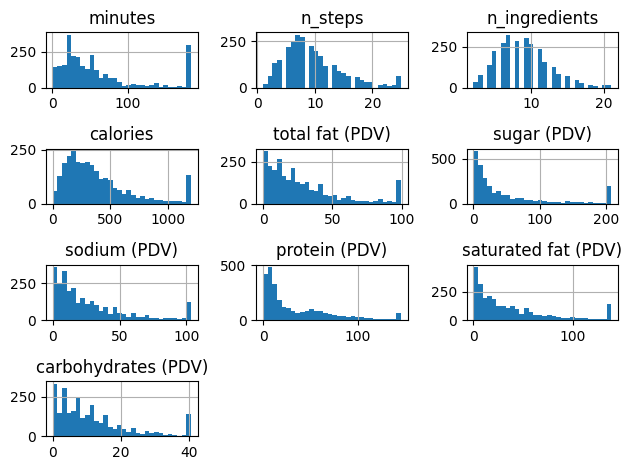

In [50]:
%matplotlib inline
fig, ax = plt.subplots()
filtered_recipes[num_cols].hist(ax=ax, bins=30)
fig.tight_layout()
plt.show();

#### Pisirme suresi (40 dk alti-Less than 40 mins & ustu - More than 40 mins)
#### Kalori Kisitlamasi  (400 cal alti-Low Calory & ustu - High Calory)

### Nihai segment karari :

SEG1 - Less than 40 minutes & Low Calory

SEG2 - Less than 40 minutes & High Calory

SEG3 - More than 40 minutes & Low Calory

SEG4 - More than 40 minutes & High Calory

In [79]:
#Segmentlere düşen tarif sayısı incelenir
print('SEG1 - Less than 40 minutes & Low Calory :',len(filtered_recipes[(filtered_recipes.minutes<=40)&(filtered_recipes.calories<=400)]))
print('SEG2 - Less than 40 minutes & High Calory :',len(filtered_recipes[(filtered_recipes.minutes<=40)&(filtered_recipes.calories>400)]))
print('SEG3 - More than 40 minutes & Low Calory :',len(filtered_recipes[(filtered_recipes.minutes>40)&(filtered_recipes.calories<=400)]))
print('SEG4 - More than 40 minutes & High Calory :',len(filtered_recipes[(filtered_recipes.minutes>40)&(filtered_recipes.calories>400)]))

SEG1 - Less than 40 minutes & Low Calory : 1001
SEG2 - Less than 40 minutes & High Calory : 393
SEG3 - More than 40 minutes & Low Calory : 734
SEG4 - More than 40 minutes & High Calory : 592


In [52]:
#SEG 1 Dagilimi
filtered_recipes[(filtered_recipes.minutes<=40)&(filtered_recipes.calories<=400)].describe()

,id,minutes,contributor_id,n_steps,n_ingredients,calories,total fat (PDV),sugar (PDV),sodium (PDV),protein (PDV),saturated fat (PDV),carbohydrates (PDV)
count,1001.000000,1001.000000,1.001000e+03,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000
mean,93481.702298,22.998002,3.704392e+06,7.728272,7.871129,200.257742,13.899101,32.338162,16.001499,16.911089,17.654346,6.571429
std,83470.188157,10.752767,8.053025e+07,3.776253,3.162337,100.940531,11.091294,37.987949,19.083782,19.209453,17.583868,5.297088
min,198.000000,1.000000,2.700000e+01,1.000000,2.000000,1.700000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,33245.000000,15.000000,2.764300e+04,5.000000,5.000000,120.800000,5.000000,5.000000,4.000000,4.000000,5.000000,2.000000
50%,72608.000000,25.000000,5.254300e+04,7.000000,8.000000,192.200000,11.000000,17.000000,10.000000,9.000000,12.000000,6.000000
75%,122412.000000,30.000000,1.141280e+05,10.000000,10.000000,278.900000,21.000000,48.000000,21.000000,23.000000,26.000000,10.000000
max,524863.000000,40.000000,1.802633e+09,25.000000,21.000000,399.800000,56.000000,208.500000,103.500000,104.000000,114.000000,32.000000


In [53]:
#SEG 2 Dagilimi
filtered_recipes[(filtered_recipes.minutes<=40)&(filtered_recipes.calories>400)].describe()

,id,minutes,contributor_id,n_steps,n_ingredients,calories,total fat (PDV),sugar (PDV),sodium (PDV),protein (PDV),saturated fat (PDV),carbohydrates (PDV)
count,393.000000,393.000000,3.930000e+02,393.000000,393.000000,393.000000,393.000000,393.000000,393.000000,393.000000,393.000000,393.000000
mean,90917.750636,24.643766,1.125136e+05,9.180662,8.641221,679.929262,50.041985,69.538168,39.958015,48.201018,63.072519,19.583969
std,84479.269113,11.021793,2.248269e+05,4.784694,3.395079,253.302241,28.788176,79.447501,29.782462,35.254292,43.877734,12.710446
min,834.000000,1.000000,1.533000e+03,1.000000,2.000000,401.900000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,31184.000000,15.000000,2.764300e+04,6.000000,6.000000,474.900000,29.000000,10.000000,16.000000,18.000000,28.000000,10.000000
50%,66596.000000,25.000000,5.395900e+04,9.000000,8.000000,593.200000,43.000000,27.000000,33.000000,43.000000,53.000000,18.000000
75%,121066.000000,35.000000,1.028590e+05,12.000000,11.000000,841.400000,72.000000,135.000000,56.000000,71.000000,94.000000,30.000000
max,495577.000000,40.000000,2.689034e+06,25.000000,20.000000,1199.800000,99.500000,208.500000,103.500000,146.000000,138.500000,40.500000


In [56]:
#SEG 3 Dagilimi
filtered_recipes[(filtered_recipes.minutes>40)&(filtered_recipes.calories<=400)].describe()

,id,minutes,contributor_id,n_steps,n_ingredients,calories,total fat (PDV),sugar (PDV),sodium (PDV),protein (PDV),saturated fat (PDV),carbohydrates (PDV)
count,734.000000,734.000000,7.340000e+02,734.000000,734.000000,734.000000,734.000000,734.000000,734.000000,734.000000,734.000000,734.000000
mean,87907.742507,96.136240,2.554829e+06,10.136240,9.166213,231.965531,14.813351,38.329019,20.277929,21.397820,18.931880,7.976839
std,82827.660939,52.495896,6.653957e+07,5.277869,3.559995,100.738191,10.747469,44.122802,20.186977,22.132487,17.228684,5.761353
min,246.000000,42.000000,1.530000e+03,1.000000,2.000000,3.700000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,30729.250000,55.000000,2.438600e+04,6.000000,7.000000,153.575000,6.000000,7.000000,7.000000,6.000000,5.000000,3.000000
50%,66497.000000,70.000000,4.933250e+04,9.000000,9.000000,235.550000,14.000000,19.000000,14.000000,11.000000,14.000000,7.000000
75%,110077.000000,140.000000,1.118365e+05,13.000000,11.000000,318.325000,22.000000,55.750000,28.000000,32.000000,29.000000,12.000000
max,517863.000000,182.500000,1.802810e+09,25.000000,21.000000,399.300000,50.000000,208.500000,103.500000,130.000000,88.000000,32.000000


In [55]:
#SEG 4 Dagilimi
filtered_recipes[(filtered_recipes.minutes>40)&(filtered_recipes.calories>400)].describe()

,id,minutes,contributor_id,n_steps,n_ingredients,calories,total fat (PDV),sugar (PDV),sodium (PDV),protein (PDV),saturated fat (PDV),carbohydrates (PDV)
count,592.000000,592.000000,5.920000e+02,592.000000,592.000000,592.000000,592.000000,592.000000,592.000000,592.000000,592.000000,592.000000
mean,93439.101351,100.909628,1.163317e+05,11.736486,10.192568,711.752703,54.293074,82.518581,46.008446,68.013514,71.077703,18.852196
std,94825.350143,51.651456,2.687807e+05,5.808112,3.766907,267.644643,26.945687,79.027954,30.251623,42.422576,40.143881,12.451756
min,536.000000,43.000000,1.533000e+03,1.000000,2.000000,400.600000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,30769.000000,60.000000,2.741475e+04,7.000000,7.000000,491.625000,35.000000,14.000000,21.000000,29.000000,39.000000,9.750000
50%,69822.000000,75.000000,5.530200e+04,10.500000,10.000000,628.250000,48.500000,43.000000,40.000000,66.000000,63.000000,16.000000
75%,111322.000000,150.000000,1.080740e+05,15.000000,13.000000,876.600000,73.500000,164.250000,66.000000,98.250000,101.000000,27.000000
max,505862.000000,182.500000,2.689073e+06,25.000000,21.000000,1199.800000,99.500000,208.500000,103.500000,146.000000,138.500000,40.500000


In [ ]:
#Segment atamalari mapping islemlerinden sonra yapilacaktir.

# Ingredients İnceleme & Mapping

In [57]:
filtered_recipes.head(3)

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,calories,total fat (PDV),sugar (PDV),sodium (PDV),protein (PDV),saturated fat (PDV),carbohydrates (PDV)
0,how i got my family to eat spinach spinach ca...,25775,50.0,37305,2002-04-22,"['60-minutes-or-less', 'time-to-make', 'course...","[166.1, 16.0, 6.0, 32.0, 19.0, 26.0, 3.0]",5,"['preheat oven to 350 degrees', 'place spinach...","if spinach scares you, this is one recipe that...","['frozen chopped spinach', 'egg', 'salt', 'bla...",8,166.1,16.0,6.0,32.0,19.0,26.0,3.0
1,land of nod cinnamon buns,22526,35.0,29212,2002-03-14,"['60-minutes-or-less', 'time-to-make', 'course...","[575.3, 18.0, 116.0, 34.0, 28.0, 22.0, 34.0]",7,"['before you turn in for the night , grease a ...",i have made this several times and it's dead e...,"['rolls', 'brown sugar', 'instant vanilla pudd...",6,575.3,18.0,116.0,34.0,28.0,22.0,34.0
2,never weep whipped cream,74805,5.0,87877,2003-11-01,"['15-minutes-or-less', 'time-to-make', 'course...","[276.3, 45.0, 2.0, 1.0, 3.0, 91.0, 0.0]",4,['whip all ingredients together until firm pea...,"i don't know where i got this, but it works. t...","['whipping cream', 'vanilla instant pudding mi...",4,276.3,45.0,2.0,1.0,3.0,91.0,0.0


#### Malzeme listesi kolonundaki değerlerin 'ingr_map' verisetindeki 'replaced' kolonu ile maplenmesi ve ingredients_mapped adında bir kolon olarak verisetine eklenmesi 

In [62]:
ingr_map.head(3)

,raw_ingr,raw_words,processed,len_proc,replaced,count,id
0,"medium heads bibb or red leaf lettuce, washed,...",13,"medium heads bibb or red leaf lettuce, washed,...",73,lettuce,4507,4308
1,mixed baby lettuces and spring greens,6,mixed baby lettuces and spring green,36,lettuce,4507,4308
2,romaine lettuce leaf,3,romaine lettuce leaf,20,lettuce,4507,4308
3,iceberg lettuce leaf,3,iceberg lettuce leaf,20,lettuce,4507,4308
4,red romaine lettuce,3,red romaine lettuce,19,lettuce,4507,4308
5,head romaine lettuce,3,head romaine lettuce,20,lettuce,4507,4308
6,curly endive lettuce,3,curly endive lettuce,20,lettuce,4507,4308
7,romaine lettuce hearts,3,romaine lettuce heart,21,lettuce,4507,4308
8,baby leaf lettuce,3,baby leaf lettuce,17,lettuce,4507,4308
9,head of lettuce,3,head of lettuce,15,lettuce,4507,4308


In [26]:
import ast

# Create a dictionary mapping original ingredient names to mapped names
ingredient_mapping = dict(zip(ingr_map['raw_ingr'], ingr_map['replaced']))

# Function to replace ingredient names in a list
def replace_ingredients(ingredient_list):
    ingredients = ast.literal_eval(ingredient_list)
    return [ingredient_mapping.get(ingredient, ingredient) for ingredient in ingredients]

# Apply the function to the 'ingredients' column in filtered_recipes data frame
filtered_recipes['ingredients_mapped'] = filtered_recipes['ingredients'].apply(replace_ingredients)

In [81]:
filtered_recipes.head(2)

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,calories,total fat (PDV),sugar (PDV),sodium (PDV),protein (PDV),saturated fat (PDV),carbohydrates (PDV),ingredients_mapped
0,how i got my family to eat spinach spinach ca...,25775,50.0,37305,2002-04-22,"['60-minutes-or-less', 'time-to-make', 'course...","[166.1, 16.0, 6.0, 32.0, 19.0, 26.0, 3.0]",5,"['preheat oven to 350 degrees', 'place spinach...","if spinach scares you, this is one recipe that...","['frozen chopped spinach', 'egg', 'salt', 'bla...",8,166.1,16.0,6.0,32.0,19.0,26.0,3.0,"[frozen chopped spinach, egg, salt, black pepp..."
1,land of nod cinnamon buns,22526,35.0,29212,2002-03-14,"['60-minutes-or-less', 'time-to-make', 'course...","[575.3, 18.0, 116.0, 34.0, 28.0, 22.0, 34.0]",7,"['before you turn in for the night , grease a ...",i have made this several times and it's dead e...,"['rolls', 'brown sugar', 'instant vanilla pudd...",6,575.3,18.0,116.0,34.0,28.0,22.0,34.0,"[roll, brown sugar, instant vanilla pudding, c..."


In [60]:
# Check one of the mappings, Filter the rows containing 'extra virgin olive oil'
filtered_rows = filtered_recipes[filtered_recipes['ingredients'].apply(lambda x: 'extra virgin olive oil' in x)]
filtered_rows.head(1)

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,calories,total fat (PDV),sugar (PDV),sodium (PDV),protein (PDV),saturated fat (PDV),carbohydrates (PDV),ingredients_mapped
24,15 minute shrimp scampi,31184,15.0,44172,2002-06-14,"['15-minutes-or-less', 'time-to-make', 'course...","[596.2, 71.0, 8.0, 51.0, 53.0, 74.0, 2.0]",9,"['start salted water boiling for pasta', 'heat...",truly delicious seafood/pasta dish that is nea...,"['extra virgin olive oil', 'onion', 'garlic', ...",8,596.2,71.0,8.0,51.0,53.0,74.0,2.0,"[olive oil, onion, garlic, white wine, butter,..."


#### Map'lenmiş malzeme listesi ve tag'lerin bir listede birleştirilmesi ve merged_tags_ingredients adında bir kolon olarak verisetine eklenmesi 

In [27]:
filtered_recipes['tags'] = filtered_recipes['tags'].apply(lambda x: eval(x))

filtered_recipes['merged_tags_ingredients'] = filtered_recipes.apply(lambda row: row['ingredients_mapped'] + row['tags'], axis=1)
filtered_recipes['merged_tags_ingredients'] = filtered_recipes['merged_tags_ingredients'].apply(lambda lst: ', '.join(lst))

filtered_recipes.head(2)

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,...,n_ingredients,calories,total fat (PDV),sugar (PDV),sodium (PDV),protein (PDV),saturated fat (PDV),carbohydrates (PDV),ingredients_mapped,merged_tags_ingredients
0,how i got my family to eat spinach spinach ca...,25775,50.0,37305,2002-04-22,"[60-minutes-or-less, time-to-make, course, mai...","[166.1, 16.0, 6.0, 32.0, 19.0, 26.0, 3.0]",5,"['preheat oven to 350 degrees', 'place spinach...","if spinach scares you, this is one recipe that...",...,8,166.1,16.0,6.0,32.0,19.0,26.0,3.0,"[frozen chopped spinach, egg, salt, black pepp...","frozen chopped spinach, egg, salt, black peppe..."
1,land of nod cinnamon buns,22526,35.0,29212,2002-03-14,"[60-minutes-or-less, time-to-make, course, pre...","[575.3, 18.0, 116.0, 34.0, 28.0, 22.0, 34.0]",7,"['before you turn in for the night , grease a ...",i have made this several times and it's dead e...,...,6,575.3,18.0,116.0,34.0,28.0,22.0,34.0,"[roll, brown sugar, instant vanilla pudding, c...","roll, brown sugar, instant vanilla pudding, ci..."


#### Nihai recipe dataframí bir csv ye export edilir.

In [83]:
filtered_recipes.to_csv('final_repices_all.csv',index=False) #final tarif verisetnin tamami

# Öneriler tag'lerin ve maplenmiş malzeme listesinin birleştirilmiş halde bulunduğu 'merged_tags_ingredients' kolonundaki kelimelerin benzerliği üzerinden yapılacaktır. Veri artık segmentlere ayrılmaya ve bu segmentler üzerinden similarity hesaplanmasına hazırdır.

# Verisetinin segmentlere göre ayrı dataframe'lere bölünmesi

In [84]:
#Segment yapısı ve sayısını yeniden hatırlayalım
print('SEG1 - Less than 40 minutes & Low Calory :',len(filtered_recipes[(filtered_recipes.minutes<=40)&(filtered_recipes.calories<=400)]))
print('SEG2 - Less than 40 minutes & High Calory :',len(filtered_recipes[(filtered_recipes.minutes<=40)&(filtered_recipes.calories>400)]))
print('SEG3 - More than 40 minutes & Low Calory :',len(filtered_recipes[(filtered_recipes.minutes>40)&(filtered_recipes.calories<=400)]))
print('SEG4 - More than 40 minutes & High Calory :',len(filtered_recipes[(filtered_recipes.minutes>40)&(filtered_recipes.calories>400)]))

SEG1 - Less than 40 minutes & Low Calory : 1001
SEG2 - Less than 40 minutes & High Calory : 393
SEG3 - More than 40 minutes & Low Calory : 734
SEG4 - More than 40 minutes & High Calory : 592


In [28]:
#Segment dataframeleri oluşturulur
seg1=filtered_recipes[(filtered_recipes.minutes<=40)&(filtered_recipes.calories<=400)]
seg2=filtered_recipes[(filtered_recipes.minutes<=40)&(filtered_recipes.calories>400)]
seg3=filtered_recipes[(filtered_recipes.minutes>40)&(filtered_recipes.calories<=400)]
seg4=filtered_recipes[(filtered_recipes.minutes>40)&(filtered_recipes.calories>400)]

In [29]:
# Set the index of seg dataframes as the recipe names
seg1.set_index('name', inplace=True)
seg2.set_index('name', inplace=True)
seg3.set_index('name', inplace=True)
seg4.set_index('name', inplace=True)

In [67]:
#del filtered_recipes

# TF - IDF Vectorizer oluşturulması ve cosine similarity üzerinden uzaklık değerlendirilmesi işlemi fonksiyon haline getirilir

In [30]:
def tf_idf_vectorizer(dataframe,corpus_col):
    # Create the TF-IDF vectorizer
    vectorizer = TfidfVectorizer(stop_words="english")

    # Fit and transform the recipe corpus
    recipe_corpus = dataframe[corpus_col]
    tfidf_matrix = vectorizer.fit_transform(recipe_corpus)
    
    return vectorizer, tfidf_matrix


def get_similar_top5(vectorizer,tfidf_matrix,user_input):
    # Transform the user input using the fitted vectorizer
    user_input_tfidf = vectorizer.transform(user_input)
    
    # Compute the cosine similarity between user input and recipe corpus
    cosine_sim = cosine_similarity(user_input_tfidf, tfidf_matrix)
    
    # Get the indices of top 5 similar recipes
    similar_top5 = list(cosine_sim.argsort()[0][-5:])
    
    return similar_top5
    
    
def get_names_top5(dataframe,similar_top5):
    # Get the names of top 5 recommended recipes
    recommended_recipes = list(dataframe.iloc[similar_top5].index)
    return recommended_recipes

In [31]:
#Tahmin işlemleri için test edilecek user_input listesi oluşturulur

#user_input = ['chicken', 'garlic', 'tomatoes', 'olive oil']
user_input = ['meat', 'garlic', 'tomatoes', 'olive oil', '60-minutes-or-less']

## SEG1 için modelin kurulması ve öneri yapılması 

In [35]:
#Model kurulumu
seg1_vectorizer, seg1_tfidf_matrix = tf_idf_vectorizer(seg1,'merged_tags_ingredients')

#Girilen user input'a göre top 5 tarifin önerilmesi
similar_top5_indices=get_similar_top5(seg1_vectorizer,seg1_tfidf_matrix,user_input)
get_names_top5(seg1,similar_top5_indices)

['donna s seasoned hamburger patties',
 'baked buffalo chicken breasts',
 'montreal steak',
 'fried bologna sandwich',
 'cube steaks au poivre']

In [121]:
#seg1
pickle.dump(seg1_vectorizer, open('seg1_vectorizer.pkl','wb')) 
pickle.dump(seg1_tfidf_matrix, open('seg1_tfidf_matrix.pkl', 'wb'))

## SEG2 için modelin kurulması ve öneri yapılması  & pickle dosyalarinin dump edilmesi

In [116]:
#Model kurulumu
seg2_vectorizer, seg2_tfidf_matrix = tf_idf_vectorizer(seg2,'merged_tags_ingredients')

#Girilen user input'a göre top 5 tarifin önerilmesi
similar_top5_indices=get_similar_top5(seg2_vectorizer,seg2_tfidf_matrix,user_input)
get_names_top5(seg2,similar_top5_indices)

['classic blt sandwich',
 'marinade for flank steak',
 'easy  creamy hamburger stroganoff',
 'kinda like chick fil a sandwiches',
 'kittencal s beef or pork marinade and tenderizer']

In [118]:
#seg2
pickle.dump(seg2_vectorizer, open('seg2_vectorizer.pkl','wb')) 
pickle.dump(seg2_tfidf_matrix, open('seg2_tfidf_matrix.pkl', 'wb'))

## SEG3 için modelin kurulması ve öneri yapılması 

In [124]:
#Model kurulumu
seg3_vectorizer, seg3_tfidf_matrix = tf_idf_vectorizer(seg3,'merged_tags_ingredients')

#Girilen user input'a göre top 5 tarifin önerilmesi
similar_top5_indices=get_similar_top5(seg3_vectorizer,seg3_tfidf_matrix,user_input)
get_names_top5(seg3,similar_top5_indices)

['crock pot rustic lamb stew',
 'crock pot beef stew',
 'chicken tortilla soup ii',
 'blender quiche   or whatever you have in your kitchen leftover',
 'crock pot hungarian goulash']

In [125]:
#seg3
pickle.dump(seg3_vectorizer, open('seg3_vectorizer.pkl','wb')) 
pickle.dump(seg3_tfidf_matrix, open('seg3_tfidf_matrix.pkl', 'wb'))

## SEG4 için modelin kurulması ve öneri yapılması 

In [126]:
#Model kurulumu
seg4_vectorizer, seg4_tfidf_matrix = tf_idf_vectorizer(seg4,'merged_tags_ingredients')

#Girilen user input'a göre top 5 tarifin önerilmesi
similar_top5_indices=get_similar_top5(seg4_vectorizer,seg4_tfidf_matrix,user_input)
get_names_top5(seg4,similar_top5_indices)

['fabulous beef stew',
 'tortured chicken   beer can',
 'the best browned beef stew ever',
 'beef stroganoff   crock pot',
 'creamy turkey tetrazzini']

In [127]:
#seg4
pickle.dump(seg4_vectorizer, open('seg4_vectorizer.pkl','wb')) 
pickle.dump(seg4_tfidf_matrix, open('seg4_tfidf_matrix.pkl', 'wb'))